# Problem Set 3
## Fundamentals of Simulation Methods

#### Author:    Elias Olofsson

#### Version information:
        2020-11-25: v.1.0. First public release. 


In [1]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

## Exercise 2 - Integration of a stiff equation (8 pts)
#### Part (a) - Implementation with constant step size $\Delta t$

In [2]:
kB = 1.38 * 10**-23     # Boltzmann's constant      (J/K)
nH = 10**6              # Number density hydrogen   (m^-3)
lambda0 = 10**-35       # Cooling rate constant     (J*m^3*s^-1)
T0 = 20000              # Temperature threshold     (K)
alpha = 10.0            # Function parameter        (1)
beta = -0.5             # Function parameter        (1)

def lambda_f(T):
    if T <= T0:
        return lambda0*(T/T0)**alpha
    else:
        return lambda0*(T/T0)**beta

def f(T):
    return -2/(3*kB)*nH*lambda_f(T)

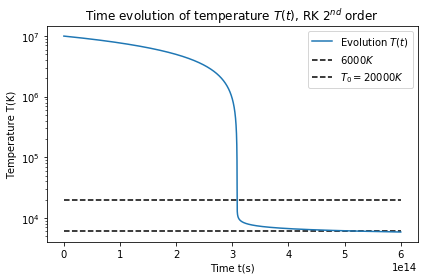

In [3]:
T_init = 10**7      # Initial temperature   (K)
dt = 10**10         # Stepsize              (s)
N = 6*10**4         # Total simulated steps (1)

T = np.zeros(N)
T[0] = T_init

# Integrate using RK 2nd order
for i in range(N-1):
    k1 = f(T[i])
    k2 = f(T[i]+k1*dt)
    T[i+1] = T[i] + dt*(k1+k2)/2

# Plot the time evolution of T(t)
t = np.arange(N)*dt
plt.plot(t,T,label='Evolution $T(t)$')
plt.yscale('log')
plt.xlabel('Time t(s)')
plt.ylabel('Temperature T(K)')
plt.hlines(6000,min(t),max(t),linestyles='dashed', label='$6000K$')
plt.hlines(T0,min(t),max(t),linestyles='dashed', label='$T_0 = 20000K$')
plt.legend()
plt.title('Time evolution of temperature $T(t)$, RK $2^{nd}$ order')
plt.tight_layout()

# Save vectors T and t for comparison in part (c)
T_constdt = T
t_constdt = t

Here, we needed roughly $N \simeq 10^5$ timesteps, each of size $\Delta t = 10^{10} s$ in order for the temperature to drop below 6000K. 

#### Part (b) - Unstable simulation with large $\Delta t$
By playing with the stepsize, we can see that the simulation quickly becomes unstable for larger $\Delta t$. We only need to increase $\Delta t$ by one order of magnitude to $10^{11}$ for the integration to break down, and the temperature vanishes completely.   

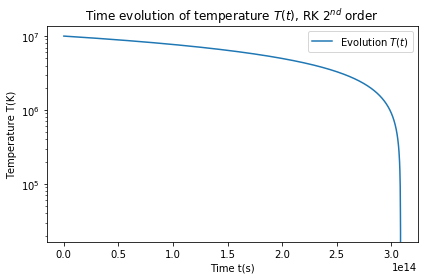

In [4]:
T_init = 10**7      # Initial temperature   (K)
dt = 10**11         # Stepsize              (s)
N = 6*10**4         # Total simulated steps (1)

T = np.zeros(N)
T[0] = T_init

# Integrate using RK 2nd order
for i in range(N-1):
    k1 = f(T[i])
    k2 = f(T[i]+k1*dt)
    T[i+1] = T[i] + dt*(k1+k2)/2

# Plot the time evolution of T(t)
t = np.arange(N)*dt
plt.plot(t,T,label='Evolution $T(t)$')
plt.yscale('log')
plt.xlabel('Time t(s)')
plt.ylabel('Temperature T(K)')
plt.legend()
plt.title('Time evolution of temperature $T(t)$, RK $2^{nd}$ order')
plt.tight_layout()

#### Part (c) - Adaptive step size implementation
Here we instead use an adaptive step size implementation for the normal RK 2nd order scheme. If the estimated local trunctation error is above 50K, then the the stepsize is halved and the integration step is re-calculated. 

If the estimated local trunctation error is smaller than 5K, then the timestep is doubled for the next timestep. This obeys that the trunctation error for the doubled step does not exceed the local threshold 50K, which can be formulated as
\begin{align}
    &\epsilon \cdot 2^{p+1} = \epsilon \cdot 2^{3} < \epsilon_0 = 50 K\\
    &\Longrightarrow \quad \epsilon < \frac{\epsilon_0}{2^{3}} = 6.25 K,
\end{align}
where $\epsilon$ is the local trunctation error for the next (doubled) timestep, and $\epsilon_0$ is the local error bound of 50K.

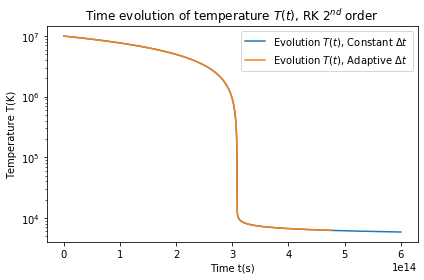

In [5]:
T_init = 10**7      # Initial temperature           (K)
N = 79              # Total simulated steps         (1)

dt = 10**15         # Initial Stepsize              (s)
errmax_loc = 50     # Local error bound in T        (K)
errmin_loc = 5      # Local lower error bound in T  (K)

T = np.zeros(N)
t = np.zeros(N)

T[0] = T_init
T_tmp = -1 

# Integrate using RK 2nd, with adaptive step size adjustments.
for i in range(N-1):
    T_i = T[i]
    t_i = t[i]
    flag = True
    while flag:
        # Take a step of size dt => y_A
        if T_tmp == -1: # Utlilize middle step y_B if it already has been calulated
            k1 = f(T_i)
            k2 = f(T_i+k1*dt)
            T_nextA = T_i + dt*(k1+k2)/2
        else:
            T_nextA = T_tmp

        # Take two steps of stepsize dt/2 => y_B
        k1 = f(T_i)
        k2 = f(T_i+k1*dt/2)
        T_tmp = T_i + dt/2*(k1+k2)/2

        k1 = f(T_tmp)
        k2 = f(T_tmp+k1*dt/2)
        T_nextB = T_tmp + dt/2*(k1+k2)/2

        # Error estimate y = |y_A - y_B|
        err_est = abs(T_nextA - T_nextB)

        # If error is larger than bound, discard the step, half dt and start over.
        if err_est > errmax_loc:
            dt = dt*0.5
        # If error is much smaller than bound, keep y_b and double dt for next timestep.
        elif err_est < errmin_loc:
            T[i+1] = T_nextB
            t[i+1] = t[i] + dt
            dt = 2*dt
            flag = False    # Escape while-loop
            T_tmp = -1      # Clear middle step.
        # Else, keep y_b and retain dt for next timestep.
        else:
            T[i+1] = T_nextB
            t[i+1] = t[i] + dt
            flag = False    # Escape while-loop
            T_tmp = -1      # Clear middle step.


# Plot graph for comparison of adaptive vs constant step size. 
plt.plot(t_constdt, T_constdt,label='Evolution $T(t)$, Constant $\Delta t$')
plt.plot(t,T,label='Evolution $T(t)$, Adaptive $\Delta t$')
plt.yscale('log')
plt.xlabel('Time t(s)')
plt.ylabel('Temperature T(K)')
plt.legend()
plt.title('Time evolution of temperature $T(t)$, RK $2^{nd}$ order')
plt.tight_layout()

We can see here in this figure that the adaptive stepsize implementation yields the same solution as the normal RK 2nd order scheme with constant stepsize. 

To confirm that the scheme is robust for large initial stepsizes, we choose $\Delta t_{init} = 10^{15}s$, which would overstep the entire time interval in the figure above in a single step. However, this is dynamically adjusted and corrected such that the scheme integrates correctly and gives a result within the given error bound.

## Exercise 3 - Double pendulum (8 pts)
#### Part (b) - Second order Runge Kutta

We first define the system parameters and the functions $\vec{f}$ in our ODE
\begin{equation}
\frac{\mathrm{d} \vec{y}}{\mathrm{~d} t}=\vec{f}(\vec{y}),
\end{equation}
for the 4-vector $\vec{y} = (\phi_1, \phi_2, q_1, q_2)$.

In [6]:
# System parameters
g = 1
m1 = 0.5
m2 = 1.0
l1 = 2.0
l2 = 1.0

def C1(phi1, phi2):
    return (l1**2)*(l2**2)*((m1+m2)*m2 - (m2**2)*np.cos(phi1-phi2)**2)

def f1(phi1,phi2,q1, q2):
    num = m2*(l2**2)*q1 - m2*l1*l2*np.cos(phi1-phi2)*q2
    den = C1(phi1,phi2)
    return num/den 

def f2(phi1,phi2,q1, q2):
    num = (m1+m2)*(l1**2)*q2 - m2*l1*l2*np.cos(phi1-phi2)*q1
    den = C1(phi1,phi2)
    return num/den 

def f3(phi1,phi2,q1,q2):
    tmp = f1(phi1,phi2,q1,q2)*f2(phi1,phi2,q1,q2) 
    return -m2*l1*l2*np.sin(phi1-phi2)*tmp - g*(m1+m2)*l1*np.sin(phi1)

def f4(phi1,phi2,q1,q2):
    tmp = f1(phi1,phi2,q1,q2)*f2(phi1,phi2,q1,q2) 
    return m2*l1*l2*np.sin(phi1-phi2)*tmp - g*m2*l2*np.sin(phi2)

# Help function so f(y) can handle vector input
def f(y):
    f1_out = f1(y[0],y[1],y[2],y[3])
    f2_out = f2(y[0],y[1],y[2],y[3])
    f3_out = f3(y[0],y[1],y[2],y[3])
    f4_out = f4(y[0],y[1],y[2],y[3])
    return np.array((f1_out,f2_out,f3_out,f4_out))

We then simulate the double pendulum using Runge Kutta 2nd order.

In [7]:
# Initial conditions
phi_1_init = 50             # (deg)
phi_2_init = -120           # (deg)
phidot_1_init = 0           # (deg/s)
phidot_2_init = 0           # (deg/s)

# Simulation settings
dt = 0.05                   # Stepsize
T = 100.0                   # Total time duration

N = round(T/dt)             # Number of timesteps

# Preallocate matrix
y = np.zeros((N,4))

# Convert to radians and insert inital values into y.
(phi_1_init, phi_2_init) = np.deg2rad((phi_1_init, phi_2_init))
y[0,0:2] = (phi_1_init, phi_2_init)

# Calculate inital values of q1 and q2, insert into y.
q1_init = (m1+m2)*(l1**2)*phidot_1_init + m2*l1*l2*phidot_2_init*np.cos(phi_1_init-phi_2_init)
q2_init = m2*(l2**2)*phidot_2_init + m2*l1*l2*phidot_1_init*np.cos(phi_1_init-phi_2_init)
y[0,2:] = (q1_init,q2_init)

# Integrate with 2nd order Runge-Kutta
k1 = np.zeros(4)
k2 = np.zeros(4)
for i in range(N-1):
    k1 = f(y[i,:])
    k2 = f(y[i,:]+dt*k1)
    y[i+1,:] = y[i,:] + dt*(k1+k2)/2

# Corresponding time vector
t = dt*np.arange(N)

For fun, we can plot the pendulum in cartesian coordinates to see the movement in (x,y).

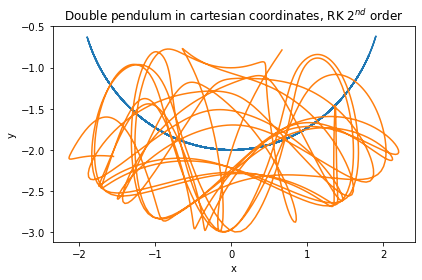

In [8]:
# Plotting the double pendulum in cartesian coordinates
plt.plot(l1*np.sin(y[:,0]),-l1*np.cos(y[:,0]))
plt.plot(l1*np.sin(y[:,0])+l2*np.sin(y[:,1]) ,-l1*np.cos(y[:,0])-l2*np.cos(y[:,1]))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Double pendulum in cartesian coordinates, RK 2$^{nd}$ order')
plt.tight_layout()

Taking the Hamiltonian of the double pendulum in eq.(13) from [Diego Assencio](https://diego.assencio.com/?index=e5ac36fcb129ce95a61f8e8ce0572dbf), we can plot the total relative energy error of the system over time.  

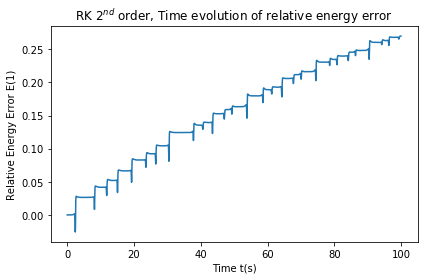

In [9]:
# Potential energy 
V = -(m1+m2)*g*l1*np.cos(y[:,0]) - m2*g*l2*np.cos(y[:,1])
# Kinetic energy
num = m2*(l2**2)*y[:,2]**2 + (m1+m2)*(l1**2)*y[:,3]**2 - 2*m2*l1*l2*y[:,2]*y[:,3]*np.cos(y[:,0]-y[:,1])
den = 2*m2*(l1**2)*(l2**2)*(m1+m2*np.sin(y[:,0]-y[:,1])**2)
T = num/den

# Hamiltonian 
H =  T + V

# Relative energy error
E_rel = (H-H[0])/H[0]
plt.plot(t,E_rel)
plt.xlabel('Time t(s)')
plt.ylabel('Relative Energy Error E(1)')
plt.title('RK $2^{nd}$ order, Time evolution of relative energy error')
plt.tight_layout()

We see here that we have a drift in total energy, even though the system is closed and frictionless. This is an numerical artifact that occurs in all simulations since we cannot calculate the true and exact velocites in the system, and thus random noise compunds and leads an steady increase in energy.

#### Part (d) - Fourth order Runge Kutta

In [10]:
# Initial conditions
phi_1_init = 50             # (deg)
phi_2_init = -120           # (deg)
phidot_1_init = 0           # (deg/s)
phidot_2_init = 0           # (deg/s)

# Simulation settings
dt = 0.05                   # Stepsize
T = 100.0                   # Total time duration

N = round(T/dt)             # Number of timesteps

# Preallocate matrix
y = np.zeros((N,4))

# Convert to radians and insert inital values into y.
(phi_1_init, phi_2_init) = np.deg2rad((phi_1_init, phi_2_init))
y[0,0:2] = (phi_1_init, phi_2_init)

# Calculate inital values of q1 and q2, insert into y.
q1_init = (m1+m2)*(l1**2)*phidot_1_init + m2*l1*l2*phidot_2_init*np.cos(phi_1_init-phi_2_init)
q2_init = m2*(l2**2)*phidot_2_init + m2*l1*l2*phidot_1_init*np.cos(phi_1_init-phi_2_init)
y[0,2:] = (q1_init,q2_init)

# Integrate with 4nd order Runge-Kutta
k1 = np.zeros(4)
k2 = np.zeros(4)
k3 = np.zeros(4)
k4 = np.zeros(4)
for i in range(N-1):
    k1 = f(y[i,:])
    k2 = f(y[i,:]+dt/2*k1)
    k3 = f(y[i,:]+dt/2*k2)
    k4 = f(y[i,:]+dt*k3)
    y[i+1,:] = y[i,:] + dt*(k1/6+k2/3+k3/3+k4/6)

# Corresponding time vector
t = dt*np.arange(N)

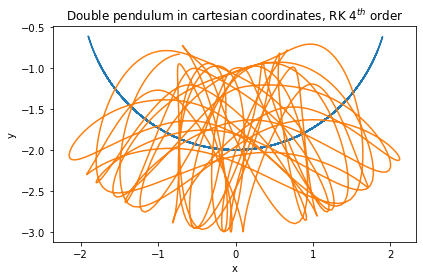

In [11]:
# Plotting the double pendulum in cartesian coordinates
plt.plot(l1*np.sin(y[:,0]),-l1*np.cos(y[:,0]))
plt.plot(l1*np.sin(y[:,0])+l2*np.sin(y[:,1]) ,-l1*np.cos(y[:,0])-l2*np.cos(y[:,1]))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Double pendulum in cartesian coordinates, RK 4$^{th}$ order')
plt.tight_layout()

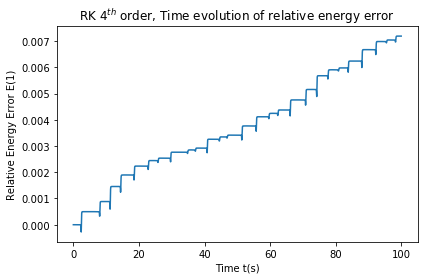

In [12]:
# Potential energy 
V = -(m1+m2)*g*l1*np.cos(y[:,0]) - m2*g*l2*np.cos(y[:,1])
# Kinetic energy
num = m2*(l2**2)*y[:,2]**2 + (m1+m2)*(l1**2)*y[:,3]**2 - 2*m2*l1*l2*y[:,2]*y[:,3]*np.cos(y[:,0]-y[:,1])
den = 2*m2*(l1**2)*(l2**2)*(m1+m2*np.sin(y[:,0]-y[:,1])**2)
T = num/den

# Hamiltonian 
H =  T + V

# Relative energy error
E_rel = (H-H[0])/H[0]
plt.plot(t,E_rel)
plt.xlabel('Time t(s)')
plt.ylabel('Relative Energy Error E(1)')
plt.title('RK $4^{th}$ order, Time evolution of relative energy error')
plt.tight_layout()

Here the energy drift is smaller than in the Runge Kutta 2nd order scheme, which is to be expected due to the higher accuracy of this 4th order scheme.

#### Part (e) - Chaos
If we simulate two double pendulums with almost identical initial conditions, we can see how extremely sensitive this system is to its initial conditions.

Pendulum 1:   

In [13]:
# Initial conditions
phi_1_init = 50             # (deg)
phi_2_init = -120           # (deg)
phidot_1_init = 0           # (deg/s)
phidot_2_init = 0           # (deg/s)

# Simulation settings
dt = 0.05                   # Stepsize
T = 150.0                   # Total time duration

N = round(T/dt)             # Number of timesteps

# Preallocate matrix
y = np.zeros((N,4))

# Convert to radians and insert inital values into y.
(phi_1_init, phi_2_init) = np.deg2rad((phi_1_init, phi_2_init))
y[0,0:2] = (phi_1_init, phi_2_init)

# Calculate inital values of q1 and q2, insert into y.
q1_init = (m1+m2)*(l1**2)*phidot_1_init + m2*l1*l2*phidot_2_init*np.cos(phi_1_init-phi_2_init)
q2_init = m2*(l2**2)*phidot_2_init + m2*l1*l2*phidot_1_init*np.cos(phi_1_init-phi_2_init)
y[0,2:] = (q1_init,q2_init)

# Integrate with 4nd order Runge-Kutta
k1 = np.zeros(4)
k2 = np.zeros(4)
k3 = np.zeros(4)
k4 = np.zeros(4)
for i in range(N-1):
    k1 = f(y[i,:])
    k2 = f(y[i,:]+dt/2*k1)
    k3 = f(y[i,:]+dt/2*k2)
    k4 = f(y[i,:]+dt*k3)
    y[i+1,:] = y[i,:] + dt*(k1/6+k2/3+k3/3+k4/6)

# Corresponding time vector
t = dt*np.arange(N)

# Saving result in new matrix for later comparison
y_test1 = y
t_test1 = t

Pendulum 2:

In [14]:
# Initial conditions
phi_1_init = 50.00001       # (deg)
phi_2_init = -120           # (deg)
phidot_1_init = 0           # (deg/s)
phidot_2_init = 0           # (deg/s)

# Simulation settings
dt = 0.05                   # Stepsize
T = 150.0                   # Total time duration

N = round(T/dt)             # Number of timesteps

# Preallocate matrix
y = np.zeros((N,4))

# Convert to radians and insert inital values into y.
(phi_1_init, phi_2_init) = np.deg2rad((phi_1_init, phi_2_init))
y[0,0:2] = (phi_1_init, phi_2_init)

# Calculate inital values of q1 and q2, insert into y.
q1_init = (m1+m2)*(l1**2)*phidot_1_init + m2*l1*l2*phidot_2_init*np.cos(phi_1_init-phi_2_init)
q2_init = m2*(l2**2)*phidot_2_init + m2*l1*l2*phidot_1_init*np.cos(phi_1_init-phi_2_init)
y[0,2:] = (q1_init,q2_init)

# Integrate with 4nd order Runge-Kutta
k1 = np.zeros(4)
k2 = np.zeros(4)
k3 = np.zeros(4)
k4 = np.zeros(4)
for i in range(N-1):
    k1 = f(y[i,:])
    k2 = f(y[i,:]+dt/2*k1)
    k3 = f(y[i,:]+dt/2*k2)
    k4 = f(y[i,:]+dt*k3)
    y[i+1,:] = y[i,:] + dt*(k1/6+k2/3+k3/3+k4/6)

# Corresponding time vector
t = dt*np.arange(N)

# Saving result in new matrix for later comparison
y_test2 = y
t_test2 = t

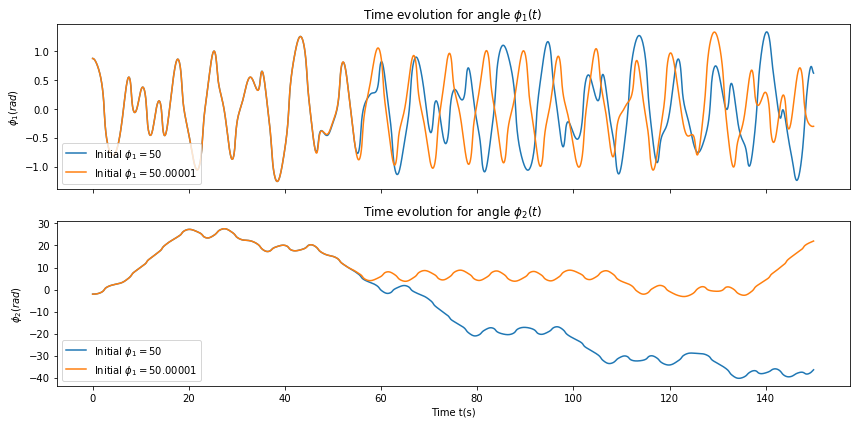

In [15]:
# Compare the time evolution for two simulations with almost identical initial conditions.
fig, axes = plt.subplots(2, 1,figsize=(12, 6), squeeze=True, constrained_layout=True,sharex=True)
axes[0].plot(t, y_test1[:,0], label='Initial $\phi_1 = 50$')
axes[0].plot(t, y_test2[:,0], label='Initial $\phi_1 = 50.00001$')
axes[1].plot(t, y_test1[:,1], label='Initial $\phi_1 = 50$')
axes[1].plot(t, y_test2[:,1], label='Initial $\phi_1 = 50.00001$')
axes[1].set_xlabel("Time t(s)")
axes[0].set_ylabel("$\phi_1(rad)$")
axes[1].set_ylabel("$\phi_2(rad)$")
axes[0].legend(loc='lower left')
axes[1].legend()
axes[0].set_title('Time evolution for angle $\phi_1(t)$')
axes[1].set_title('Time evolution for angle $\phi_2(t)$')
plt.tight_layout()

Here we see how the two pendulums initially seems to follow each other almost perferctly. However, after some finite time period has passed, the two systems diverges gradually until there is no similarity left between them. During the final time period of this simulation, one could think that these to pendulums have nothing in common.

This shows how extremely sensitive this non-linear chaotic system is to initial conditions, and how hopeless it is to predict the movement of a physical pendulum past a certain time horizon. 